In [1]:
from glob import glob
import os.path as op
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import cohen_kappa_score, jaccard_similarity_score
%matplotlib inline

/usr/local/lib/python3.4/dist-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
import nibabel as nib
from nibabel.streamlines import load as load_trk
import dipy.tracking.streamline as dts
import dipy.tracking.utils as dtu
from skimage.transform import resize
from scipy.ndimage.morphology import binary_dilation
import dipy.data as dpd

In [3]:
import keras
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, LeakyReLU
from keras.layers import Conv2D, MaxPooling2D

Using TensorFlow backend.


In [4]:
from keratin.networks import vgg16

In [5]:
import bundlenet as bn

In [6]:
dpd.fetch_bundles_2_subjects()

Data size is approximately 234MB
Dataset is already in place. If you want to fetch it again please first remove the folder /home/ariel/.dipy/exp_bundles_and_maps 


({'bundles_2_subjects.tar.gz': ('https://digital.lib.washington.edu/researchworks/bitstream/handle/1773/38477/bundles_2_subjects.tar.gz',
   '97756fbef11ce2df31f1bedf1fc7aac7')},
 '/home/ariel/.dipy/exp_bundles_and_maps')

In [7]:
ls /home/ariel/.dipy/exp_bundles_and_maps/bundles_2_subjects/subj_1/bundles/

bundles_af.left.trk   bundles_cg.left.trk     bundles_mdlf.right.trk
bundles_af.right.trk  bundles_cg.right.trk    bundles_slf1.left.trk
bundles_cc_1.trk      bundles_cst.left.trk    bundles_slf1.right.trk
bundles_cc_2.trk      bundles_cst.right.trk   bundles_slf2.left.trk
bundles_cc_3.trk      bundles_ifof.left.trk   bundles_slf2.right.trk
bundles_cc_4.trk      bundles_ifof.right.trk  bundles_slf_3.left.trk
bundles_cc_5.trk      bundles_ilf.left.trk    bundles_slf_3.right.trk
bundles_cc_6.trk      bundles_ilf.right.trk   bundles_uf.left.trk
bundles_cc_7.trk      bundles_mdlf.left.trk   bundles_uf.right.trk


In [8]:
bundle_files = glob('/home/ariel/.dipy/exp_bundles_and_maps/bundles_2_subjects/subj_1/bundles/*.trk')

In [9]:
t1_img = nib.load('/home/ariel/.dipy/exp_bundles_and_maps/bundles_2_subjects/subj_1/t1_warped.nii.gz')

In [10]:
n_streamlines = []
bundle_names = []
for fname in bundle_files:
    bundle_names.append(fname.split('/')[-1].split('bundles_')[-1].split('.trk')[0])
    streamlines = bn.read_sl(fname) 
    n_streamlines.append(len(streamlines))

In [11]:
bundle_names

['cg.left',
 'slf1.left',
 'ifof.left',
 'slf2.left',
 'cc_1',
 'cc_2',
 'cst.left',
 'af.left',
 'mdlf.left',
 'uf.right',
 'ilf.left',
 'slf_3.left',
 'cst.right',
 'cc_7',
 'cg.right',
 'cc_6',
 'slf1.right',
 'cc_5',
 'slf2.right',
 'slf_3.right',
 'ilf.right',
 'mdlf.right',
 'uf.left',
 'cc_4',
 'ifof.right',
 'cc_3',
 'af.right']

In [12]:
np.min(n_streamlines), len(n_streamlines)

(161, 27)

In [13]:
take_n_bundles = 27
take_n_sl = 160

In [14]:
if op.exists('./subject1_bundles.npz'):
    # Read it from file:
    loaded_from_file = np.load('./subject1_bundles.npz')
    labels_test = loaded_from_file['labels_test']
    labels_train = loaded_from_file['labels_train']
    data_test = loaded_from_file['data_test']
    data_train = loaded_from_file['data_train']
    data_valid = loaded_from_file['data_valid']
    labels_valid = loaded_from_file['labels_valid']
else:
    data_train, data_valid, data_test, labels_train, labels_valid, labels_test =\
    bn.partition_data(bundle_files, t1_img.shape, take_n_bundles, take_n_sl)    
    np.savez('./subject1_bundles', data_train=data_train, labels_train=labels_train,
                                   data_test=data_test, labels_test=labels_test, 
                                   data_valid=data_valid, labels_valid=labels_valid)

In [15]:
img_rows = 100
img_cols = 100
batch_size = 4
epochs = 24
num_classes = take_n_bundles
input_shape = (img_rows, img_cols, 1)

In [16]:
labels_train = keras.utils.to_categorical(labels_train-1, num_classes)
labels_valid = keras.utils.to_categorical(labels_valid-1, num_classes)
labels_test  = keras.utils.to_categorical(labels_test-1, num_classes)

In [17]:
# model = Sequential()
# model.add(Conv2D(32, kernel_size=(3, 3),
#                  activation='relu',
#                  input_shape=input_shape))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(num_classes, activation='softmax'))

In [18]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',input_shape=input_shape,padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2),padding='same'))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1))                  
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='linear'))
model.add(Dropout(0.25))
model.add(LeakyReLU(alpha=0.1))                  
model.add(Dense(num_classes, activation='softmax'))

In [19]:
from IPython.display import SVG
from vis_utils import plot_model
plot_model(model, to_file='model.png')

In [20]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [21]:
filepath="checkpoints/weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [22]:
training = model.fit(data_train, labels_train,
                     batch_size=batch_size,
                     epochs=epochs,
                     verbose=1,
                     validation_data=(data_valid, labels_valid),
                     callbacks=callbacks_list)

Train on 2592 samples, validate on 864 samples
Epoch 1/24
2592/2592 [==============================] - 21s - loss: 0.5911 - acc: 0.8106 - val_loss: 0.2060 - val_acc: 0.9317
Epoch 2/24
2592/2592 [==============================] - 20s - loss: 0.2090 - acc: 0.9252 - val_loss: 0.1906 - val_acc: 0.9236
Epoch 3/24
2592/2592 [==============================] - 20s - loss: 0.1691 - acc: 0.9371 - val_loss: 0.1572 - val_acc: 0.9410
Epoch 4/24
2592/2592 [==============================] - 20s - loss: 0.1523 - acc: 0.9367 - val_loss: 0.1511 - val_acc: 0.9468
Epoch 5/24
2592/2592 [==============================] - 20s - loss: 0.1311 - acc: 0.9491 - val_loss: 0.1335 - val_acc: 0.9514
Epoch 6/24
2592/2592 [==============================] - 19s - loss: 0.1143 - acc: 0.9541 - val_loss: 0.1462 - val_acc: 0.9502
Epoch 7/24
2592/2592 [==============================] - 20s - loss: 0.1190 - acc: 0.9495 - val_loss: 0.1298 - val_acc: 0.9583
Epoch 8/24
2592/2592 [==============================] - 20s - loss: 0.1

In [23]:
model.load_weights("checkpoints/weights.best.hdf5")

In [24]:
score = model.evaluate(data_test, labels_test, verbose=0)

In [25]:
print(score)

[0.16301287497494676, 0.96412037037037035]


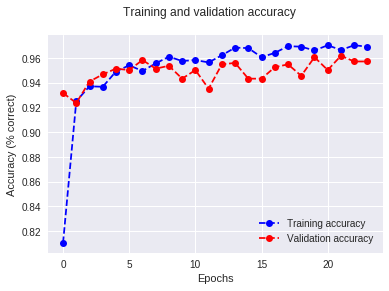

In [26]:
fig = bn.plot_accuracy(training)

In [27]:
p = model.predict(data_test, batch_size=5)
p_idx = np.argmax(p, axis=-1)
p_bundles = np.array([bundle_names[ii] for ii in p_idx])
loaded_from_file = np.load('./subject1_bundles.npz')
labels_test = loaded_from_file['labels_test']
actual_labels = np.array([bundle_names[ii] for ii in (labels_test - 1).astype(int)])
print("Percent correct is %s " % np.mean(p_bundles == actual_labels))

kappa = cohen_kappa_score(p_bundles, actual_labels)
print("Kappa is: %s" % kappa)
jaccard = jaccard_similarity_score(p_bundles, actual_labels)
print("Jaccard is: %s" % jaccard)

Kappa is: 0.962740384615
Jaccard is: 0.96412037037


In [28]:
confusion = np.zeros((len(bundle_names), len(bundle_names)))
arr_bundle_names = np.array(bundle_names)
for xx in range(len(p_bundles)):
    idx1 = np.where(arr_bundle_names == p_bundles[xx])
    idx2 = np.where(arr_bundle_names == actual_labels[xx])
    n = np.sum(actual_labels == actual_labels[xx])
    confusion[idx1, idx2] += 1 / n

In [29]:
sort_idx = np.argsort(arr_bundle_names)

/usr/local/lib/python3.4/dist-packages/seaborn/matrix.py:143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if xticklabels == []:
/usr/local/lib/python3.4/dist-packages/seaborn/matrix.py:151: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if yticklabels == []:


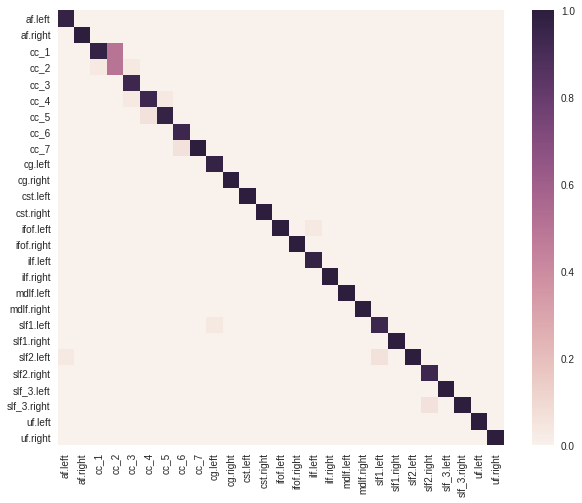

In [30]:
fig, ax = plt.subplots(1)
sns.heatmap(confusion[sort_idx][:, sort_idx],
            xticklabels=arr_bundle_names[sort_idx], 
            yticklabels=arr_bundle_names[sort_idx], ax=ax)
fig.set_size_inches([10, 8])

Cross-predict on *another subject*

In [31]:
sub2_bundle_files = glob('/home/ariel/.dipy/exp_bundles_and_maps/bundles_2_subjects/subj_2/bundles/*.trk')

In [32]:
sub2_t1_img = nib.load('/home/ariel/.dipy/exp_bundles_and_maps/bundles_2_subjects/subj_2/t1_warped.nii.gz')

In [33]:
n_streamlines = 0
for fname in sub2_bundle_files:
    streamlines = bn.read_sl(fname)
    n_streamlines += len(streamlines)

In [34]:
n_streamlines

57060

In [35]:
if not op.exists('./subject2_bundles_all.npz'):
    data_sub2 = np.zeros((n_streamlines, 100, 100, 1))
    actual_labels = np.zeros(n_streamlines, dtype=np.object)
    ii = 0
    for fname in sub2_bundle_files:
        bundle_name = fname.split('/')[-1].split('bundles_')[-1].split('.trk')[0]
        print(bundle_name)
        streamlines = bn.read_sl(fname)
        for sl in streamlines: 
            data_sub2[ii] = bn.reduce_sl(sl, t1_img.shape)
            if not np.mod(ii, 100):
                print("ii = %s"%ii)
            actual_labels[ii] = bundle_name
            ii += 1

    np.savez('./subject2_bundles_all', data_sub2=data_sub2, actual_labels=actual_labels)
else: 
    from_file = np.load('./subject2_bundles_all.npz')
    data_sub2 = from_file['data_sub2']
    actual_labels = from_file['actual_labels']

In [36]:
p = model.predict(data_sub2, batch_size=5)

In [37]:
p_idx = np.argmax(p, axis=-1)

In [38]:
p_bundles = [bundle_names[ii] for ii in p_idx]

In [39]:
from sklearn.metrics import cohen_kappa_score, jaccard_similarity_score

In [40]:
kappa = cohen_kappa_score(p_bundles, actual_labels)
print("Kappa is: %s" % kappa)
jaccard = jaccard_similarity_score(p_bundles, actual_labels)
print("Jaccard is: %s" % jaccard)

Kappa is: 0.842971057028
Jaccard is: 0.862320364529


In [41]:
np.mean(p_bundles == actual_labels)

0.86232036452856642

In [42]:
confusion = np.zeros((len(bundle_names), len(bundle_names)))
arr_bundle_names = np.array(bundle_names)
for xx in range(len(p_bundles)):
    idx1 = np.where(arr_bundle_names == p_bundles[xx])
    idx2 = np.where(arr_bundle_names == actual_labels[xx])
    n = np.sum(actual_labels == actual_labels[xx])
    confusion[idx1, idx2] += 1 / n

In [43]:
sort_idx = np.argsort(arr_bundle_names)

/usr/local/lib/python3.4/dist-packages/seaborn/matrix.py:143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if xticklabels == []:
/usr/local/lib/python3.4/dist-packages/seaborn/matrix.py:151: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if yticklabels == []:


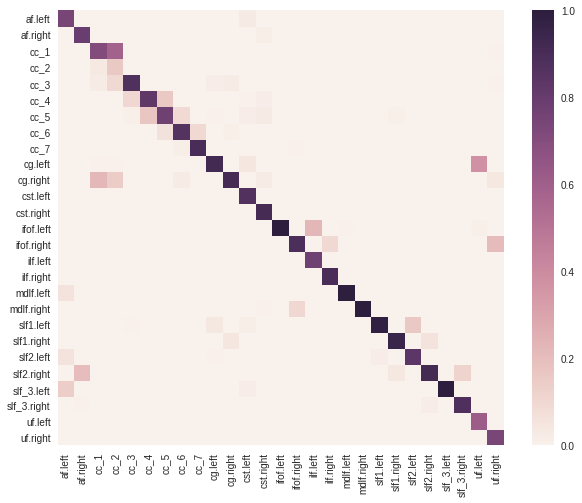

In [44]:
fig, ax = plt.subplots(1)
sns.heatmap(confusion[sort_idx][:, sort_idx],
            xticklabels=arr_bundle_names[sort_idx], 
            yticklabels=arr_bundle_names[sort_idx], ax=ax)
fig.set_size_inches([10, 8])

In [45]:
p_error = p[~(p_bundles == actual_labels)]
p_correct = p[p_bundles == actual_labels]

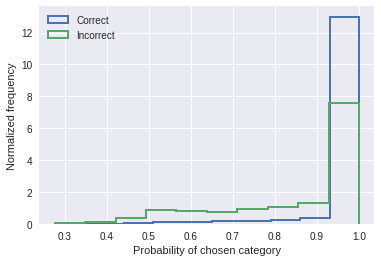

In [46]:
fig, ax = plt.subplots(1)
ax.hist(np.max(p_correct, -1), histtype='step', linewidth=2, normed=True, bins=10, label="Correct")
ax.hist(np.max(p_error, -1), histtype='step', linewidth=2, normed=True, bins=10, label="Incorrect")
ax.set_xlabel("Probability of chosen category")
ax.set_ylabel("Normalized frequency")
plt.legend(loc="upper left")